In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import torch
from torch.distributions import Normal, Uniform
from tqdm import tqdm

from neuraldistributions.utility import imread

In [2]:
def gibbs_sampler(mean, C, psi_diag, truncation_boundaries, N=1000, N_burnin=100):
    
    n, k = C.shape
    pnoise = stats.norm(np.zeros(len(psi_diag)), psi_diag)
    pz = stats.norm(0, 1)
    
    # initial values
    z_sample = np.zeros((k, 1))
    noise_sample = np.zeros((n, 1))

    tsamples = []
    for iter_n in tqdm(range(N + N_burnin)):

        # Sample 𝜖 given  𝑧
        truncation_lower_boundary_noise = truncation_boundaries[:, [0]] - mean - C @ z_sample
        truncation_upper_boundary_noise = truncation_boundaries[:, [1]] - mean - C @ z_sample
        truncation_boundaries_noise = np.hstack((truncation_lower_boundary_noise, truncation_upper_boundary_noise))

        loc = pnoise.cdf(truncation_boundaries_noise.T[0])
        scale = pnoise.cdf(truncation_boundaries_noise.T[1]) - loc
        uniform_sample = stats.uniform(loc, scale).rvs()
        noise_sample = pnoise.ppf(uniform_sample)[:, None]


        # Sample  𝑧𝑖  given  𝜖  and  𝑧∖𝑖
        for latent_ind in np.arange(k):
            latent_notind = np.where(np.arange(k) != latent_ind)[0]

            truncation_lower_boundary_z_ = (truncation_boundaries[:, [0]] - mean - C[:, latent_notind] @ z_sample[latent_notind] - noise_sample) / C[:, [latent_ind]]
            truncation_upper_boundary_z_ = (truncation_boundaries[:, [1]] - mean - C[:, latent_notind] @ z_sample[latent_notind] - noise_sample) / C[:, [latent_ind]]
            eta = (np.sign(C[:, [latent_ind]]) + 1) / 2
            aa = np.hstack((truncation_lower_boundary_z_, truncation_upper_boundary_z_))
            truncation_lower_boundary_z, truncation_upper_boundary_z = np.take_along_axis(aa, np.hstack((1-eta, eta)).astype(int), axis=1).T
            truncation_boundaries_z = np.hstack([truncation_lower_boundary_z.max(), truncation_upper_boundary_z.min()])

            ulb, uub = pz.cdf(truncation_boundaries_z)
            uniform_sample = stats.uniform(ulb, uub-ulb).rvs()
            new_z_sample = pz.ppf(uniform_sample)

            z_sample[[latent_ind]] = new_z_sample

        if iter_n >= N_burnin:
            tsamples.append(mean + C @ z_sample + noise_sample) 

    return np.concatenate(tsamples, axis=1).T

In [3]:
def get_truncation_boundaries(model, n_neurons):
    device = next(model.parameters()).device
    model.sample_transform.to("cpu")

    gaussian_linspace = torch.linspace(-10, 10, 10000)[:, None].repeat(1, n_neurons)
    inv_linspace = model.sample_transform.inv(gaussian_linspace)

    val_idx, neuron_idx = np.where(
        np.diff(torch.isnan(inv_linspace).cpu().data.numpy(), axis=0)
    )
    val_idx = val_idx + 1
    sorted_neurons_idx = np.argsort(neuron_idx)
    neuron_idx = neuron_idx[sorted_neurons_idx]
    val_idx = val_idx[sorted_neurons_idx]

    truncation_lower_boundaries = (
        gaussian_linspace[val_idx, neuron_idx].cpu().data.numpy().tolist()
    )
    truncation_upper_boundaries = [np.inf] * len(truncation_lower_boundaries)

    truncation_boundaries = np.array(
        [truncation_lower_boundaries, truncation_upper_boundaries]
    ).T

    truncation_boundaries = np.array(truncation_boundaries)

    model.sample_transform.to(device);
    
    return truncation_boundaries

In [42]:
### Stuff that do not depend on the image ###################

# load model and get the image-independent params
model = torch.load("../models/ziffa_scan2")
C_torch, psi_diag = model.C_and_psi_diag
R_torch = psi_diag.diag()
R = R_torch.cpu().data.numpy()
C = C_torch.cpu().data.numpy().T
zero_threshold = model.zero_threshold.item()
n, k = C.shape
device = next(model.parameters()).device

# get the truncation boundaries
truncation_boundaries = get_truncation_boundaries(model, n)

### Stuff that do depend on the image ###################

# load image
image_path = "arbitrary_image.jpg"
input_image = imread(image_path, xres=64, yres=36)
input_image = torch.from_numpy(input_image).to(device)

# get the image-dependent params
mean_torch, q_torch = model(input_image)
q = q_torch.cpu().data.numpy()

# specify "zero" vs "non-zero" neurons
uniform_samples = np.random.rand(n)
nonzero_neurons_idx = np.where(uniform_samples < q[0])[0]
zero_neurons_idx = np.where(uniform_samples >= q[0])[0]

# prepare params for gibbs sampling
psi_diag = np.sqrt(np.diag(R))[nonzero_neurons_idx]
mean = mean_torch.T.cpu().data.numpy()[nonzero_neurons_idx]

sample = gibbs_sampler(mean, C[nonzero_neurons_idx, :], psi_diag, truncation_boundaries[nonzero_neurons_idx])

gaussian_sample = np.zeros((1, n))
gaussian_sample[0, nonzero_neurons_idx] = sample[np.random.choice(np.arange(len(sample)))]
neural_sample = model.sample_transform(torch.from_numpy(gaussian_sample).to(device))[0].cpu().data.numpy()
neural_sample[0, zero_neurons_idx] = np.random.uniform(0, zero_threshold, size=len(zero_neurons_idx))

100%|██████████| 1100/1100 [00:10<00:00, 103.29it/s]


## Some analysis

In [112]:
gt_vars = cov_mat[np.triu(np.ones_like(cov_mat), k=1).astype(bool)]
est_vars = np.cov(tsamples)[np.triu(np.ones_like(cov_mat), k=1).astype(bool)]

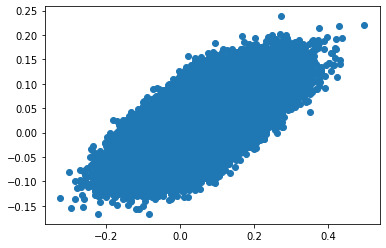

In [110]:
plt.scatter(gt_vars, est_vars)

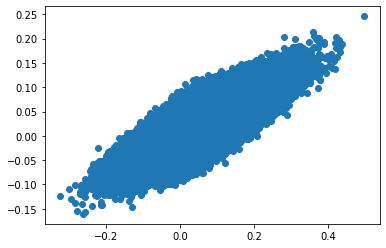

In [113]:
plt.scatter(gt_vars, est_vars)

---

## From import

In [2]:
import torch
from neuraldistributions.gibbs_sampler import generate_n_samples

In [3]:
model = torch.load("../models/ziffa_scan2")
image_path = "arbitrary_image.jpg"

In [6]:
ns = generate_n_samples(model, image_path, n_samples=3)

100%|██████████| 1100/1100 [00:10<00:00, 104.24it/s]
